In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/arabic_ocr/data.rar" "/content/drive/MyDrive/arabic_ocr/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5421.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5422.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5423.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5424.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5426.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5427.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5428.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5429.txt        99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/543.txt         99%  OK 
Extracting  /content/drive/MyDrive/arabic_ocr/data/labels/5430.txt        99%  OK 
Extracting  /content/drive/My

### import the libraries and load the file names

In [5]:
#important library imports
import numpy as np
import cv2
import os

filenames_img=sorted(os.listdir('/content/drive/MyDrive/arabic_ocr/data/images'))
filenames_labels=sorted(os.listdir('/content/drive/MyDrive/arabic_ocr/data/labels'))
filenames_imgs_split=[filename.replace('.jpg', '') for filename in filenames_img]
filenames_labels_split=[filename.replace('.txt', '') for filename in filenames_labels]
print(len(filenames_imgs_split))
print(len(filenames_labels_split))

19628
19628


In [6]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv

In [7]:
#train test validate splitting
split_idx = int(0.95 * len(filenames_imgs_split))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgs_split[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgs_split[split_idx:]


print(f"Total training samples: {len(train_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 18646
Total test samples: 982


In [8]:
from tqdm import tqdm

In [11]:
base_path='/content/drive/MyDrive/arabic_ocr/data/'
base_image_path = os.path.join(base_path, "images/")
base_labels_path = os.path.join(base_path, "labels/")
def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in tqdm(range(len(filenames_imgsplit))):
        img_path = os.path.join(
            base_image_path,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_labels_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r",  encoding="utf8")
        labels.append(label_file.read())

    return paths, labels

train_images_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
_, all_labels = get_image_paths_and_labels(filenames_img, filenames_imgs_split)

100%|██████████| 19628/19628 [00:32<00:00, 600.83it/s]


In [12]:
test_images_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

100%|██████████| 982/982 [00:01<00:00, 816.63it/s]


In [14]:
# Find maximum length and the size of the vocabulary in the training data.
characters = set()
max_len = 0

for label in all_labels:
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

Maximum length:  68
Vocab size:  64


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

characters = list(characters)
characters.sort()
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=characters, mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Save the vocabulary to a file
vocabulary = char_to_num.get_vocabulary()
with open('/content/drive/MyDrive/arabic_ocr/vocabulary.txt', 'w', encoding='utf-8') as vocab_file:
    vocab_file.truncate(0)
    vocab_file.write('\n'.join(vocabulary))

In [17]:
def load_StringLookup():

    import tensorflow as tf

    # Load the vocabulary from the saved file
    with open('vocabulary.txt', 'r', encoding='utf-8') as vocab_file:
        vocabulary = vocab_file.read().split('\n')

    # Create a new StringLookup layer with the loaded vocabulary and configuration
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=vocabulary,
        mask_token=None,  # You may need to adjust this depending on your configuration
    )

    # Mapping integers back to original characters.
    num_to_char = StringLookup(
        vocabulary= vocabulary, mask_token=None, invert=True
    )
    return char_to_num, num_to_char

In [18]:
padding_token = 99

def preprocess_image(image_paths, width, hight):
    images = []
    for path in tqdm(image_paths):
        # Load and preprocess your images here (e.g., resizing and normalizing)
        image = cv2.imread(path)  # Load the image using OpenCV
        image = cv2.resize(image, (width, hight))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, image = cv2.threshold(image, 250, 255, cv2.THRESH_BINARY)

        image = image // 255.0  # Normalize pixel values to [0, 1]

        images.append(image)
    # Next we need to reshape our data for the convolutional network
    images=np.array(images)
    images = images.reshape(images.shape[0], hight, width,1)
    return images


def vectorize_label(labels):
    vectorized_labels=[]
    for label in tqdm(labels):
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        length = tf.shape(label)[0]
        pad_amount = max_len - length
        label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
        vectorized_labels.append(label)
    return np.array( vectorized_labels)

In [19]:
train_images = preprocess_image(train_images_paths, 300, 20)

100%|██████████| 18646/18646 [00:46<00:00, 399.76it/s]


479 شارع أبو مخطوب متفرع من المنقطعة في ١٧٤ أبو ترابة


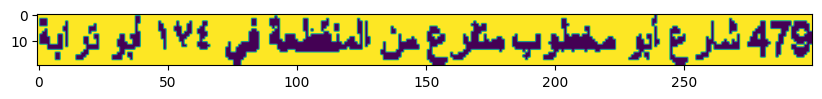

In [20]:
i=20
print(train_labels[i])
plt.figure(figsize=(10,6))
image = train_images[i]
plt.imshow(image)


In [21]:
train_vectorized_labels = vectorize_label(train_labels)

100%|██████████| 18646/18646 [02:08<00:00, 145.09it/s]


In [22]:
train_images.shape,  train_vectorized_labels.shape

((18646, 20, 300, 1), (18646, 68))

In [23]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [35]:
def build_model(width, hight):
    # Inputs to the model
    input_img = keras.Input(shape=(hight, width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.

    x = keras.layers.Conv2D(16,
                            (5, 5),
                            activation="relu",
                            padding="same",
                            name="Conv1")(input_img)

    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(32,
                            (3, 3),
                            activation="relu",
                            padding="same",
                            name="Conv2")(x)

    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block.
    x = keras.layers.Conv2D(64,
                            (3, 3),
                            activation="relu",
                            padding="same",
                            name="Conv3")(x)

    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)

    # Normalization
    x= keras.layers.BatchNormalization()(x)

    # Reshape the data
    new_shape = ((hight // 2 // 2 //2)*64, (width // 2 //2 // 2) )
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # Dense Layer
    x = keras.layers.Dense(1000, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # Normalization
    x = keras.layers.BatchNormalization()(x)

    # RNN (LSTM) Layers
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.2))(x)

    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.2))(x)

    # Dense Layer
    x = keras.layers.Dense(64, activation="relu", name="dense2")(x)
    x = keras.layers.Dropout(0.2)(x)

    # Classification Layer
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 3, activation="softmax", name="dense3"
    )(x)

    # Loss Layer
    output = CTCLayer(name="ctc_loss")(labels, x)



    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="Arabic_OCR"
    )


    # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate=0.001,
                                decay_rate=0.90,
                                decay_steps=1000)

    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


In [36]:
try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

with tf.device(DEVICE_NAME):
    model = build_model(300, 20)

Found GPU at: /device:GPU:0


In [37]:
# Get the model.
model.summary()

Model: "Arabic_OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 20, 300, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 20, 300, 16)  416         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 10, 150, 16)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 10, 150, 32)  4640        ['pool1[0][0]']         

In [38]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=3
)

# Train the model.
history = model.fit(
    x=[train_images,train_vectorized_labels],
    validation_split=0.1,
    epochs=1000,
    callbacks=[stopping],
    batch_size=32
)

Epoch 1/1000
525/525 [==============================] - 81s 132ms/step - loss: 108.2636 - val_loss: 91.8510
Epoch 2/1000
525/525 [==============================] - 55s 104ms/step - loss: 83.3506 - val_loss: 80.3932
Epoch 3/1000
525/525 [==============================] - 53s 101ms/step - loss: 77.6840 - val_loss: 74.1651
Epoch 4/1000
525/525 [==============================] - 57s 108ms/step - loss: 73.0940 - val_loss: 70.3281
Epoch 5/1000
525/525 [==============================] - 54s 103ms/step - loss: 69.6599 - val_loss: 67.0535
Epoch 6/1000
525/525 [==============================] - 55s 106ms/step - loss: 67.0152 - val_loss: 65.4479
Epoch 7/1000
525/525 [==============================] - 54s 103ms/step - loss: 64.9781 - val_loss: 64.2681
Epoch 8/1000
525/525 [==============================] - 54s 104ms/step - loss: 63.2776 - val_loss: 63.2277
Epoch 9/1000
525/525 [==============================] - 55s 104ms/step - loss: 61.6991 - val_loss: 62.4182
Epoch 10/1000
525/525 [=============

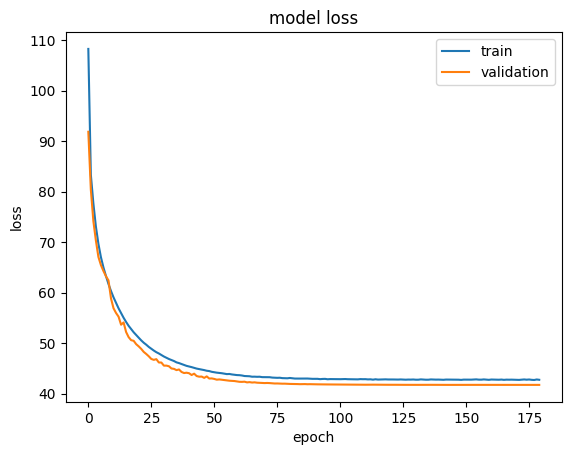

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [40]:
model.save('/content/drive/MyDrive/arabic_ocr/my_model_final.h5')

In [49]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [50]:
test_images, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

100%|██████████| 982/982 [00:01<00:00, 576.06it/s]


In [54]:
test = preprocess_image([test_images[1]], 300, 20)
preds = prediction_model.predict(test)
print("predicted: text", decode_batch_predictions(preds)[0]) , print('actual text: ',test_labels[1])


100%|██████████| 1/1 [00:00<00:00, 99.13it/s]


1/1 [==============================] - 0s 92ms/step
predicted: text 94 شارع الدوير متفرع من سوميا في ١٠١١ أم البيابين
actual text:  568 شارع الغوير متفرع من سوميا في ١٥١٢ أم المهابيش


(None, None)